#**TEXT CLASSIFICATION NOTEBOOK** 
This notebook will do the text classification. There are 4 main steps:
- Load dataset: The dataset will be import, convert and store into DataFrame
- Load Model: loading the fine-tuned model and tokernizer
- Document level classification: Do the classification in the dataset using document level
- Sentence level classification: Do the classification in the dataset using sentence level. In this step, there are various of approaches can be apply.

#Import Library

In [ ]:
!pip install transformers datasets -qq

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer,TextClassificationPipeline
from transformers import EarlyStoppingCallback

import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets import load_metric
from datasets import Dataset


import nltk
nltk.download('punkt')

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import random
import operator
import regex


In [ ]:
#run this step if you use Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

#Functions
This part contains the functions will use to do text classification

In [ ]:
#function split input document into sentences, predict the label and score of each sentence and store it into a list
def label_sentences(model,tokenizer,document):
  #declare the pipeline to do the sentence level classification
  pipe = TextClassificationPipeline(model=model,tokenizer=tokenizer,device=0)
  #split document into sentence
  sentence = nltk.tokenize.sent_tokenize(document)
  result = []

  #do the classification for each sentence and store the result into a list
  for s in sentence:
    pred = pipe(s)
    label_score = (pred[0]['label'],pred[0]['score'])
    result.append(label_score)
  return result 

The image below describes the process of label counting approach 

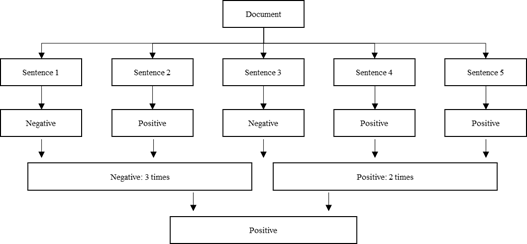

In [ ]:
#function for sentence level classification: counting label approach
#use the list of result from above, do the counting labeling
def label_counting_choosen(list_labels,mode="normal"):
  result = {}
  for i,l in enumerate(list_labels):
    label = l[0]

    #normal approach
    if mode == "normal":
        result[label] = result.get(label,0) + 1

    #start piority approach        
    elif mode =="start":
      if i== 0:
        result[label] = result.get(label,0) + 2
      else:
        result[label] = result.get(label,0) + 1
    #start piority approach 
    elif mode == "end":
        if i == (len(list_labels)-1):
          result[label] = result.get(label,0) + 2
        else:
          result[label] = result.get(label,0) + 1
  max_keys = [key for key, value in result.items() if value == max(result.values())]
  if len(max_keys) == 1:
    return random.choice(max_keys)
  else:
    if mode == "normal":
      return random.choice(max_keys)
    elif mode =="start":
      return max_keys[0]
    elif mode =="end":
      return max_keys[-1]

The image below describes the process of label scoring approach 

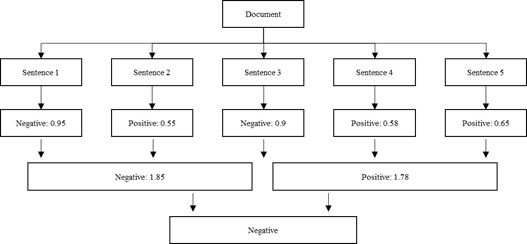

In [ ]:
#function for sentence level classification: scoring label approach
def label_scoring_choosen(list_labels):
  normal_result = {}
  start_result = {}
  end_result = {}
  prediction = {}
  for idx,ls in enumerate(list_labels):
    label = ls[0]
    score = ls[1]
    normal_result[label] = normal_result.get(label,0) + score
    if idx == 0:
      start_score = score * 2
      start_result[label] = start_result.get(label,0) + start_score
    else:
      start_result[label] = start_result.get(label,0) + score
    if idx == (len(list_labels)-1):
      end_score = score * 2
      end_result[label] = end_result.get(label,0) + end_score
    else:
      end_result[label] = end_result.get(label,0) + score
  prediction["normal"] = max(normal_result.items(), key=operator.itemgetter(1))[0]
  prediction["start"] = max(start_result.items(), key=operator.itemgetter(1))[0]
  prediction["end"] = max(end_result.items(), key=operator.itemgetter(1))[0]
  return prediction

In [ ]:
#function to calculate the metrics
def compute_metrics(eval_pred):
    metric1 = load_metric("accuracy")
    metric2 = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = metric2.compute(predictions=predictions, references=labels,average="weighted")["f1"]
    return {"accuracy": accuracy,"f1":f1}

In [ ]:
#function to convert id to label
def label2id(prediction,dict_label):
  y_pred = []
  for i in range(len(prediction)):
    pred = 0
    if prediction[i] in dict_label.keys():
      pred = dict_label[prediction[i]]
    y_pred.append(pred)
  return y_pred

In [2]:
#calculate the accuracy and F1_score base on matrics
#append prediction into exisit DataFrame
def calculate_performance(df, result_list, label2id, field_name):
  y_true = df_test_doc['label'].to_list()
  y_pred = label2id(result_list,label2id)
  df[field_name] = y_pred
  accuracy = accuracy_score(y_true,y_pred)
  f1_score = f1_score(y_true,y_pred,average="weighted")
  return accuracy, f1_score

#3. Load dataset
Load one of the testing dataset below before run the classification. 
- Define the df_test dataset and load data into it.
- Define id2label , label2id variable for testing.

##AG News

In [ ]:
#download test.csv from https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset
df_test = pd.read_csv('test.csv')

In [ ]:
id2label={0: 'world', 1: 'sports',2:'business',3:'science'}
label2id = {'world': 0,'sports': 1,'business': 2,'science':3}

##DBPEdia

In [ ]:
dbpedia_14_test = load_dataset('dbpedia_14',split="test[:80%]")
df_dbpedia_14_test = pd.DataFrame(dbpedia_14_test)

df_test = df_dbpedia_14_test[df_dbpedia_14_test['label'].isin(list(range(0,8)))].copy(deep=True)

In [ ]:
id2label = {0: "Company", 1: "EducationalInstitution",2: "Artist",3: "Athlete",4: "OfficeHolder",5: "MeanOfTransportation",6: "Building",7: "NaturalPlace"}
label2id = {"Company": 0,"EducationalInstitution": 1,"Artist": 2,"Athlete": 3,"OfficeHolder": 4,"MeanOfTransportation": 5,"Building": 6,"NaturalPlace": 7}

##Yelp Review

In [ ]:
def cleanText(text):
    # HTML tags
    text = regex.sub(r"<[^<]+?>","",text)
    text = text.encode().decode('unicode_escape').replace("\n",".")
    text = text.replace(".",". ")
    text = text.replace(" "," ")
    return text

In [ ]:
yelp_review_test = load_dataset('yelp_review_full',split="test")
df_test = pd.DataFrame(yelp_review_test)

In [ ]:
id2label= {0: 'negative', 1: 'positive',2:'neutral'}
label2id = {"negative": 0, "positive": 1, "neutral":2}

##Amazon Polarity

In [ ]:
#load imdb testing dataset from HuggingFace
amazon_polarity_test = load_dataset('amazon_polarity',split='test[:5%]')
#convert to DataFrame
df_amazon_polarity_test = pd.DataFrame(amazon_polarity_test)
#drop unnecessary columns
df_amazon_polarity_test.drop("title",inplace=True,axis=1)
#rename columns
df_amazon_polarity_test.rename(columns = {'content':'text'}, inplace = True)
#copy to df_test
df_test = df_amazon_polarity_test.copy(deep=True)

In [ ]:
id2label= {0: 'negative', 1: 'positive'}
label2id = {"negative": 0, "positive": 1}

##IMDB Review

In [ ]:
def cleanText(text):
    # HTML tags
    text = regex.sub(r"<[^<]+?>","",text)
    text = text.encode().decode('unicode_escape').replace("\n",".")
    text = text.replace(".",". ")
    text = text.replace(" "," ")
    return text

In [ ]:
imdb_review = load_dataset('imdb')

In [ ]:
imdb_review_test = imdb_review["test"]
imdb_review_test

In [ ]:
df_imdb_review_test = pd.DataFrame(imdb_review_test)
df_imdb_review_test["text"] = df_imdb_review_test["text"].apply(cleanText)

In [ ]:
df_test = df_imdb_review_test.copy(deep = True)

#Load Pre-trained Model

In [ ]:
#the path store the fine-tuned model. Change it before use
model_path = ''

In [ ]:
#load fine-tuned model for text classification
model = AutoModelForSequenceClassification.from_pretrained(model_path,id2label=id2label)

#load tokenizer for text classification
tokenizer = AutoTokenizer.from_pretrained(model_path,padding="max_length", truncation=True)

#tokenzize function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
#create variables to store the results
metrics_result = pd.DataFrame()

method = []
accuracy = []
f1 = []

#Document level classification

In [ ]:
#create DataFrame for document level classification
df_test_doc = df_test.copy(deep=True)
df_test_doc

In [ ]:
#convert DataFrame to Dataset
test_dataset = Dataset.from_pandas(df_test_doc)

#tokenized dataset
tokenized_datasets_test = test_dataset.map(tokenize_function, batched=True)

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", 
                                  evaluation_strategy="epoch",
                                  save_strategy = "epoch",
                                  num_train_epochs=5,
                                  per_device_eval_batch_size=16,
                                  )

#define the Trainer to evaluate the files
eval = Trainer(
  model=model,
  args=training_args,
  train_dataset=tokenized_datasets_test,
  compute_metrics=compute_metrics,
)

#document classification
pred = eval.predict(tokenized_datasets_test)
print(pred)

In [ ]:
preds = np.argmax(pred.predictions, axis=-1)
preds

In [ ]:
method.append("Document level")
accuracy.append(pred[2]["test_accuracy"])
f1.append(pred[2]["test_f1"])

In [ ]:
df_test_doc["doc_preds"] = preds

#Sentence level classification

In [ ]:
df_test_sent = df_test.copy(deep=True)

In [ ]:
df_test_sent['text'] = df_test_sent['text'].apply(cleanText)

In [ ]:
#stored lists for counting approaches
normal_prediction_count = []
start_prediction_count = []
end_prediction_count = []

#stored lists for scroring approaches
normal_prediction_score = []
start_prediction_score = []
end_prediction_score = []

#list store sentence level prediction
sentence_pred_result = []

for i in range(len(df_test_doc)):
  doc = df_test_doc["text"].iloc[[i]].values[0]
  result = label_sentences(model,tokenizer,doc)
  
  #storing results 
  sentence_pred_result.append(result)

  #counting approaches
  normal_pred = label_counting_choosen(result)
  normal_prediction_count.append(normal_pred)
  start_pred = label_counting_choosen(result,"start")
  start_prediction_count.append(start_pred)
  end_pred = label_counting_choosen(result,"end")
  end_prediction_count.append(end_pred)

  #scoring approaches
  prediction_dict = label_scoring_choosen(result)
  normal_prediction_score.append(prediction_dict["normal"])
  start_prediction_score.append(prediction_dict["start"])
  end_prediction_score.append(prediction_dict["end"])


In [ ]:
df_test["sentence_lv_result"] = sentence_pred_result

###Sentence level: Counting method

In [ ]:
#counting label approach: normal
field_name = "sen_pred_normal_count"
accuracy, f1_score = calculate_performance(df_test_sent, normal_prediction_count, label2id, field_name)

method.append("Sentence level: Norm (Count)")
accuracy.append(accuracy)
f1.append(f1_score)

In [ ]:
#counting label approach: start piority
field_name = "sen_pred_start_count"
accuracy, f1_score = calculate_performance(df_test_sent, start_prediction_count, label2id, field_name)

method.append("Sentence level: Start (Count)")
accuracy.append(accuracy)
f1.append(f1_score)

In [ ]:
#counting label approach: end piority
field_name = "sen_pred_end_count"
accuracy, f1_score = calculate_performance(df_test_sent, end_prediction_count, label2id, field_name)

method.append("Sentence level: End (Count)")
accuracy.append(accuracy)
f1.append(f1_score)

###Sentence level: Scoring method

In [ ]:
#Scoring label approach: normal
field_name = "sen_pred_normal_score"
accuracy, f1_score = calculate_performance(df_test_sent, normal_prediction_count, label2id, field_name)

method.append("Sentence level: Norm (Scoring)")
accuracy.append(accuracy)
f1.append(f1_score)

In [ ]:
#Scoring label approach: start piority
field_name = "sen_pred_start_score"
accuracy, f1_score = calculate_performance(df_test_sent, start_prediction_score, label2id, field_name)

method.append("Sentence level: Start (Scoring)")
accuracy.append(accuracy)
f1.append(f1_score)

In [ ]:
#Scoring label approach: end piority
field_name = "sen_pred_end_score"
accuracy, f1_score = calculate_performance(df_test_sent, end_prediction_score, label2id, field_name)

method.append("Sentence level: End (Scoring)")
accuracy.append(accuracy)
f1.append(f1_score)

In [ ]:
#store result 
metrics_result["Method"] = method
metrics_result["Accuracy"] = [round(acc,6)*100 for acc in accuracy]
metrics_result["F1"] = [round(f,6)*100 for f in f1]

#Saving result
This part export the result after do the text classification to csv file. The main purposes of these file are storing result (avoid re-run the text classification) and do re-use for the analytics. 

In [ ]:
#the path store final result. Change it before use
result_path = ""

#store the metrics values. Change the name
save_result_path = result_path + "metrics_result.csv"
metrics_result.to_csv(save_result_path,index=False)

#store the DataFrame with prediction result of all documents
save_df_path = result_path + "df_results.csv"
df_test_doc.to_csv(save_df_path,index=False,sep="|")